In [1]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot ### to read, convert, inspect ROOT TTrees
import matplotlib as mpl

from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

import matplotlib.ticker as mtick # for 1e10 format on Axis


In [2]:
# Loading the datasets

hdl_mc = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/MC_train_112361_LHC22b1b/LcSignal.root", "LcSignal")
# hdl_data = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/DATA_train_Lc_112997/LcData_df_0_40.root", "LcData")
hdl_data = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/DATA_train_Lc_112997/LcData_df_0_80_new.root", "LcData")

# removing extra tails which are far from signal region

# hdl_data.apply_preselections("fM > 2.2 and fM < 2.4", inplace=True)
# hdl_mc.apply_preselections("fM > 2.2 and fM < 2.4", inplace=True)

hdl_data.apply_preselections("fM > 2.2 and fM < 2.4", inplace=True)
hdl_mc.apply_preselections("fM > 2.2 and fM < 2.4", inplace=True)

In [3]:
# Using Tight selection for data

tpcSigKa_min = -3
tpcSigKa_max = 3

pt_min = 2
pt_max = 3

## Selections from Cut based analysis 
cpa_min=0.95
cpa_max=1.0

DL_min=0.02

cutList=[
    f'fNSigTpcKa1 > {tpcSigKa_min}',
    f'fNSigTpcKa1 < {tpcSigKa_max}',
    f'fPt > {pt_min}',
    f'fPt < {pt_max}',
    f'fCpa > {cpa_min}',    
    f'fCpa < {cpa_max}',
    f'fDecayLength > {DL_min}'
]
allCuts = ' & '.join(cutList)
allCuts = f' {allCuts} '  # Add spaces around the string

# Applying the same Tight selection criteira for data and MC
hdl_data.apply_preselections(allCuts, inplace=True)
hdl_mc.apply_preselections(allCuts, inplace=True)

# plot_utils.plot_distr([hdl_mc, hdl_data], cols_to_be_compared, 
#                       bins=30, labels=['MC', 'Data'],
#                       log=1, density=1, figsize=(20, 20), alpha=0.3, grid=False);
print('Size of samples for training \nData = ',len(hdl_data), ', Signal = ', len(hdl_mc))

Size of samples for training 
Data =  647070 , Signal =  1444


In [4]:
# Selecting Bkg from given dataset

fractionData=0.04 # this is the fraction of total data used in training 
hdl_bkg=hdl_data.shuffle_data_frame(frac=fractionData, inplace=False)

# cloning the dataset in handler format 
hdl_data_application = hdl_data

# convering dataset into pandas
df_totalData = hdl_data.get_data_frame()
df_BDTTraining = hdl_bkg.get_data_frame()

# dataset for the appication: dropping the data used for BDT training
df_application = pd.concat([df_totalData,df_BDTTraining]).drop_duplicates(keep=False)

# converting the pandas dataframe into handler format 
hdl_data_application.set_data_frame(df_application)

# Signal region for Lc is removed, ~ 5 sigma around the signal i.e. Mass = 2.284 GeV/c^2 
hdl_bkg.apply_preselections("fM < 2.26 or fM > 2.31", inplace=True)

print('Size of samples for training \nBkg = ',len(hdl_bkg), ', Signal = ', len(hdl_mc))

Size of samples for training 
Bkg =  19175 , Signal =  1444


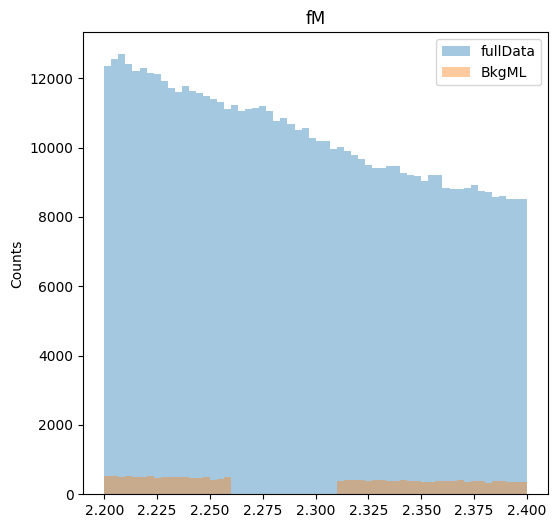

In [5]:
plot_utils.plot_distr([hdl_data_application,hdl_bkg], 'fM', 
                      bins=60, labels=['fullData', 'BkgML','sd'],
                      log=0, density=0, figsize=(6, 6), alpha=0.4, grid=False);

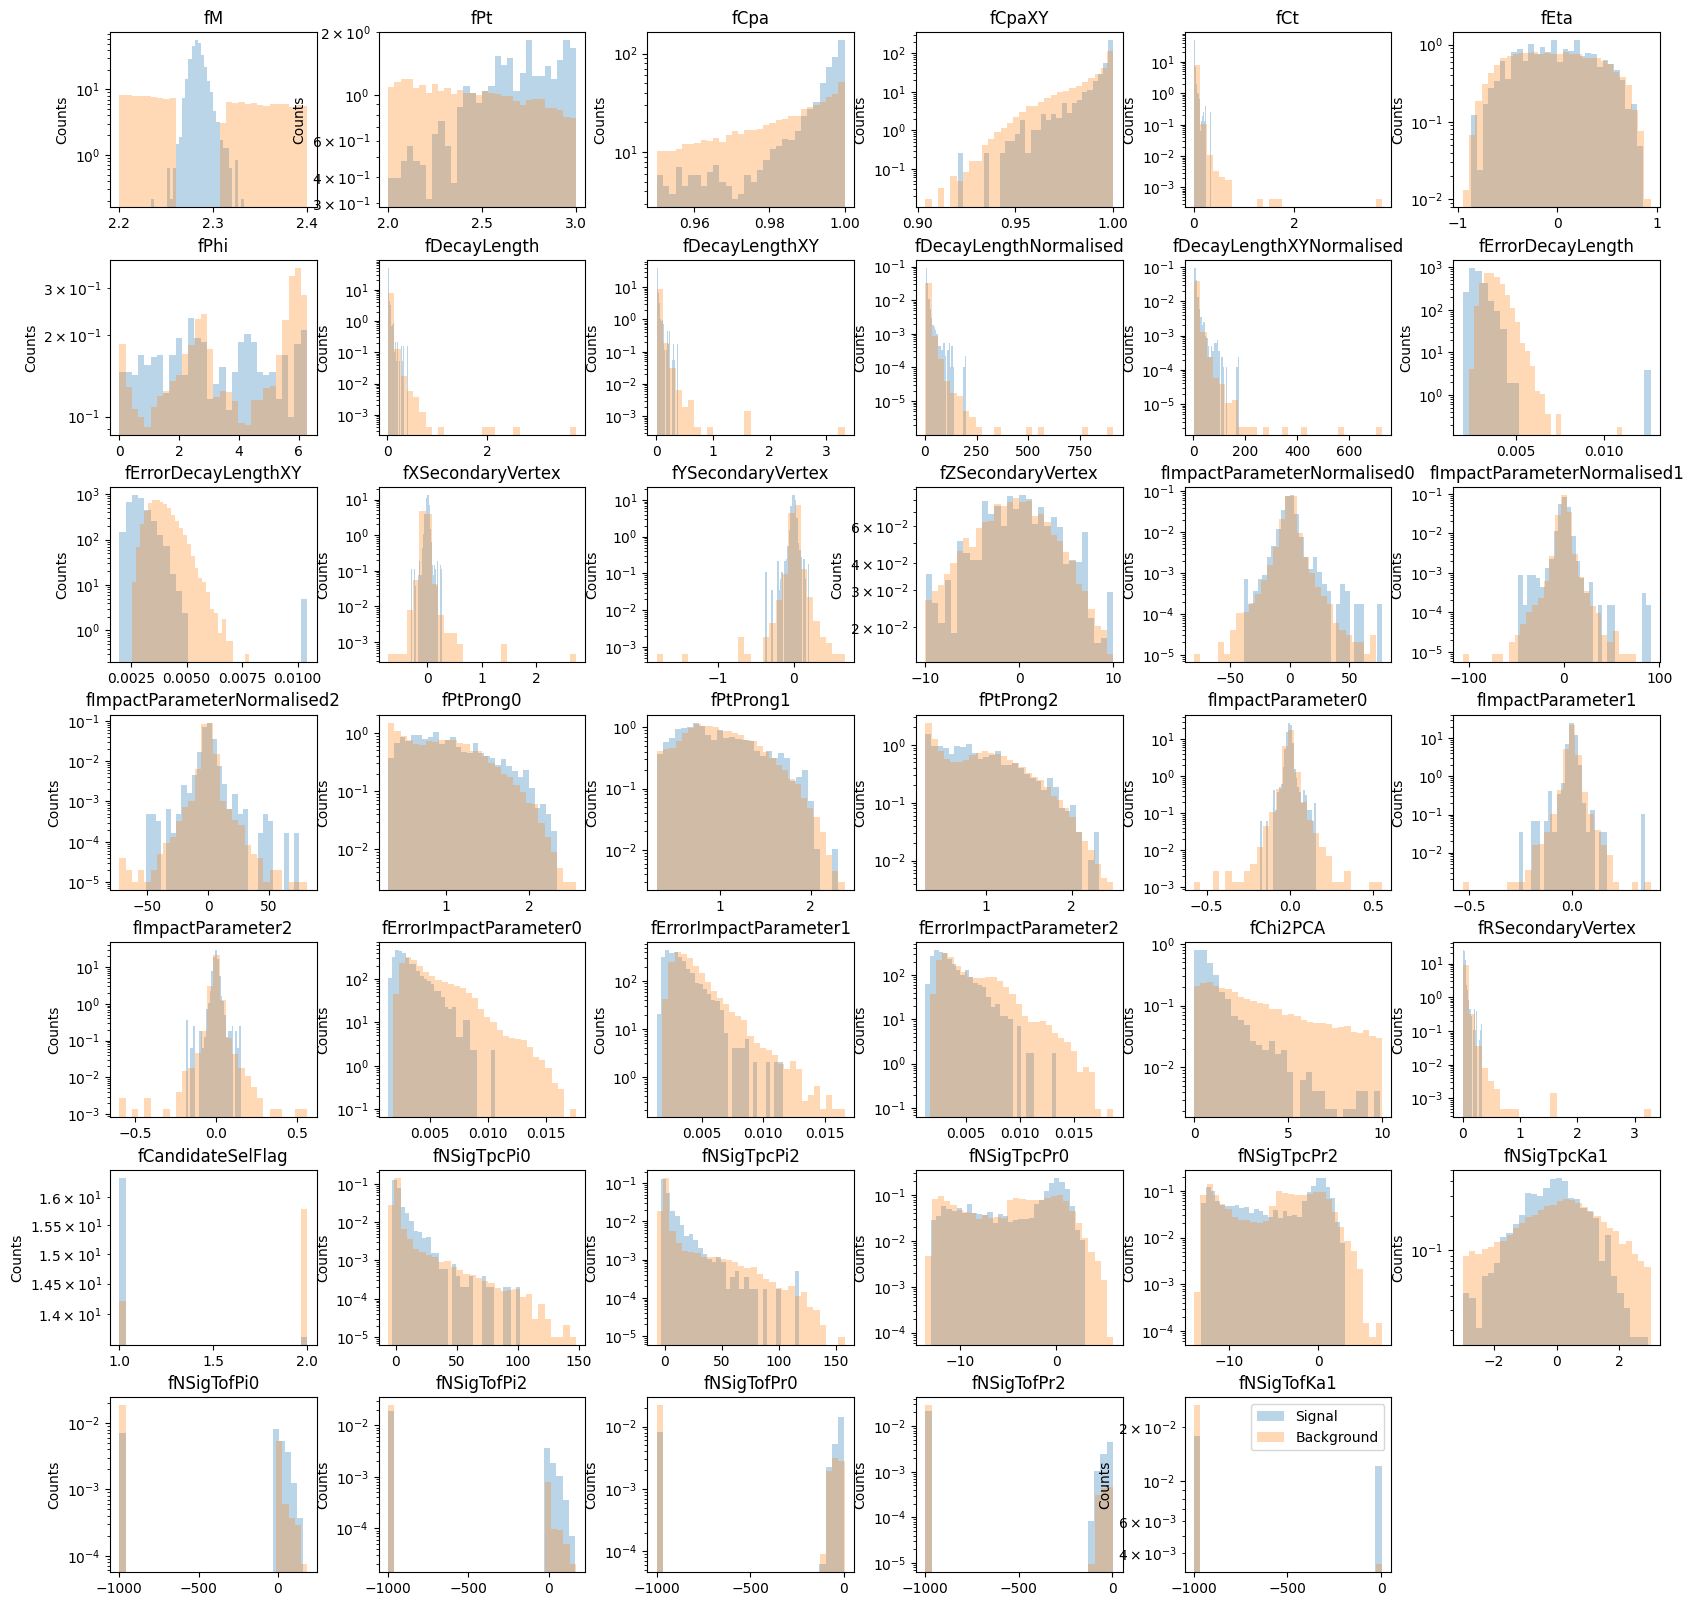

In [6]:
cols_to_be_compared = ['fM','fPt','fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',  'fErrorDecayLength', 'fErrorDecayLengthXY', 
                            'fXSecondaryVertex', 'fYSecondaryVertex','fZSecondaryVertex',
                           'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
                           'fPtProng0', 'fPtProng1', 'fPtProng2',
                           'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
                           'fErrorImpactParameter0', 'fErrorImpactParameter1', 'fErrorImpactParameter2', 'fChi2PCA', 'fRSecondaryVertex', 'fCandidateSelFlag',
                           'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                           'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1'
                      ]

# ## some matplotlib tuning is needed to display all the features
plot_utils.plot_distr([hdl_mc, hdl_bkg], cols_to_be_compared, 
                      bins=30, labels=['Signal', 'Background'],
                      log=1, density=True, figsize=(20, 20), alpha=0.3, grid=False);

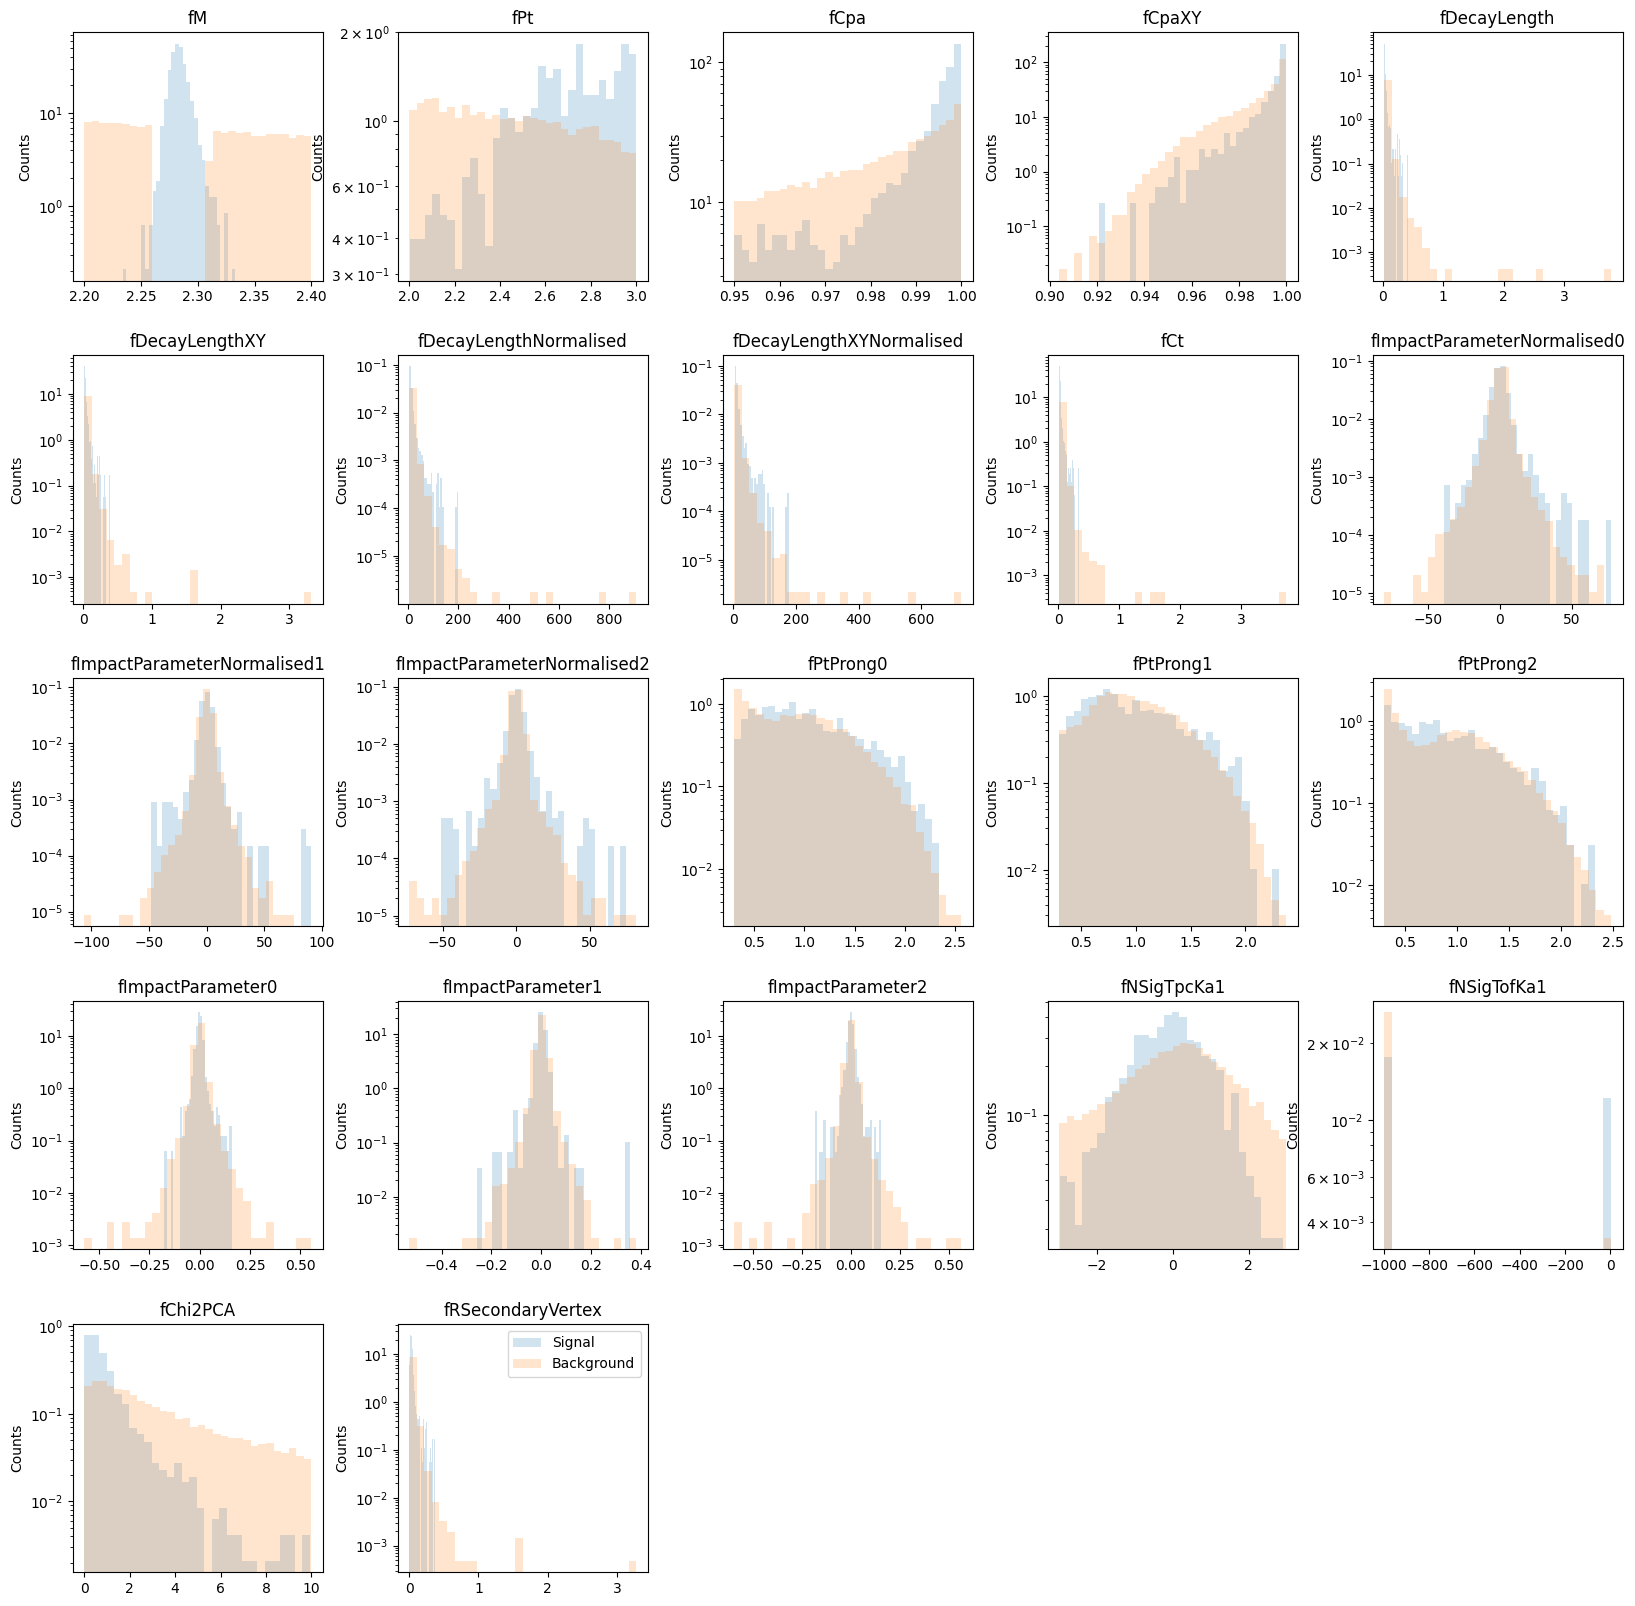

In [7]:
cols_to_plot = ['fM','fPt','fCpa','fCpaXY',
                 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',
                 'fCt',
                 'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
                 'fPtProng0', 'fPtProng1', 'fPtProng2',
                 'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
                 'fNSigTpcKa1', 'fNSigTofKa1',
                 'fChi2PCA',
                 'fRSecondaryVertex'
                ]

abc=plot_utils.plot_distr([hdl_mc, hdl_bkg], cols_to_plot, 
                      bins=30, labels=['Signal', 'Background'],
                      log=1, density=True, figsize=(20, 20), alpha=0.2, grid=False);

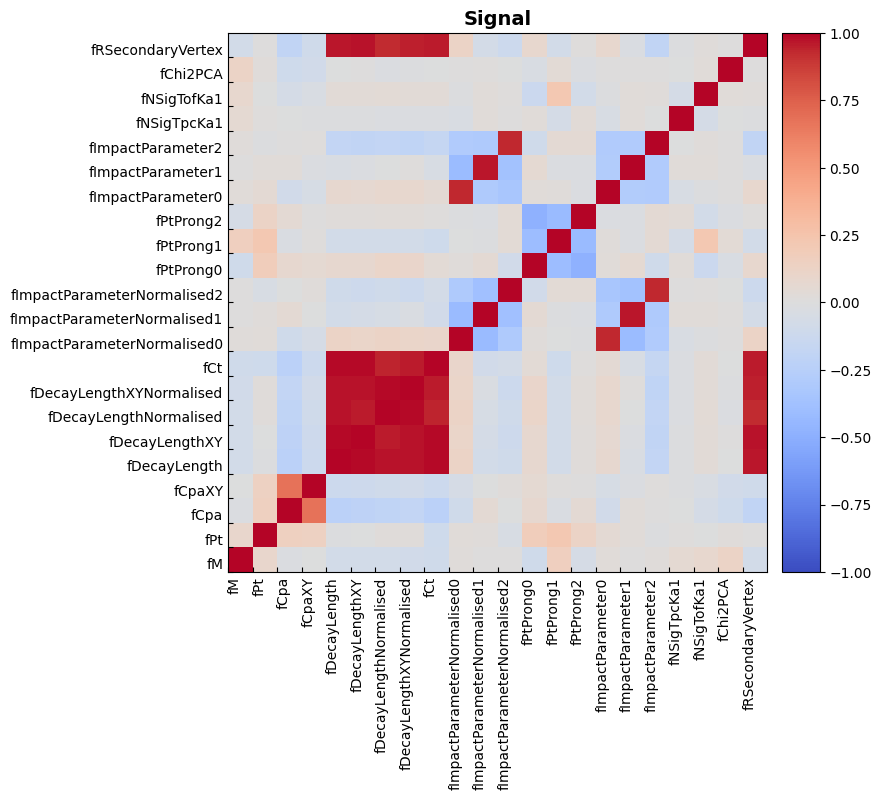

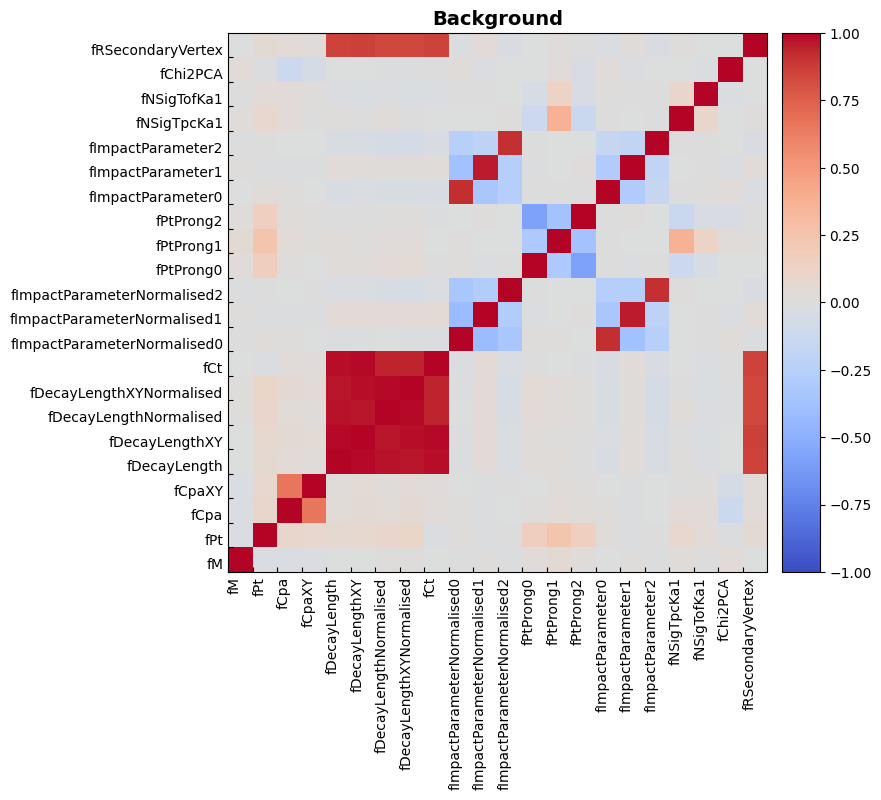

In [8]:
plot_utils.plot_corr([hdl_mc, hdl_bkg], cols_to_plot, labels=['Signal', 'Background']);

In [5]:
# training_cols = ['fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised','fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
#                 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1', 'fErrorDecayLength' , 'fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']

# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
training_cols = ['fCpa','fCpaXY',
                 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',
                 'fCt',
                 'fXSecondaryVertex', 'fYSecondaryVertex','fZSecondaryVertex',
                           'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
                           'fPtProng0', 'fPtProng1', 'fPtProng2',
                           'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
                           'fErrorImpactParameter0', 'fErrorImpactParameter1', 'fErrorImpactParameter2',
                 'fNSigTpcKa1', 'fNSigTofKa1',
#                  'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1',
#                  'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                 'fChi2PCA',
                 'fRSecondaryVertex'
                 
                ]
# train_test_data is a combined dataset of data and MC
train_test_data = analysis_utils.train_test_generator([hdl_bkg, hdl_mc], [0, 1], test_size=0.6, random_state=42)

print('Size of train sample: ', len(train_test_data[0]))
print('Size of test sample: ', len(train_test_data[3]))


Size of train sample:  18207
Size of test sample:  27312


## Training and testing a BDT

We will use the BDT of XGBoost (https://github.com/dmlc/xgboost): boosting is implemented with a gradient descent method. It features few hyperparameters that can be tuned to improve the performance and reduce the overfitting, even if the algorithm works smoothly out of the box.



In [25]:
from sklearn.neural_network import MLPClassifier
# alpha=0.01: regularization L1 or L2
#  l1_ratio=0.5: controls the L1 and L2
clf_NN = MLPClassifier(solver='adam', alpha=0.01, hidden_layer_sizes=(70,50,40,20,40,50,70), random_state=1,max_iter=400, early_stopping=True)
model_hdl = ModelHandler(clf_NN, training_cols)

In [26]:
clf_NN.early_stopping

True

## Optimize the model on the provided data

from optuna.samplers import RandomSampler

N_JOBS=8

hyper_pars_ranges = {'n_estimators': (20, 300), 'max_depth': (2, 6), 'learning_rate': (0.01, 0.1)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

In [27]:
model_hdl.fit(train_test_data[0], train_test_data[1])
score_test = model_hdl.predict(train_test_data[2], output_margin=False)

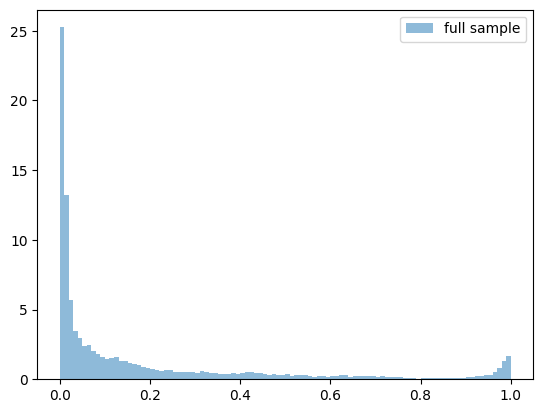

In [28]:
#### plot the score distribution
plt.hist(score_test, bins=100, label='full sample', alpha=0.5, density=True);
plt.legend();

Two peaks clearly distinguishable: will they be corresponding to the signal and the background? Let's plot the two distribution separately

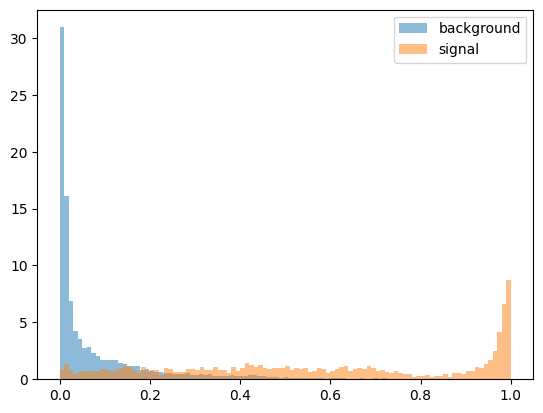

In [29]:
plt.hist(score_test[train_test_data[3]==0], bins=100, label='background', alpha=0.5, density=True);
plt.hist(score_test[train_test_data[3]==1], bins=100, label='signal', alpha=0.5, density=True);
plt.legend();

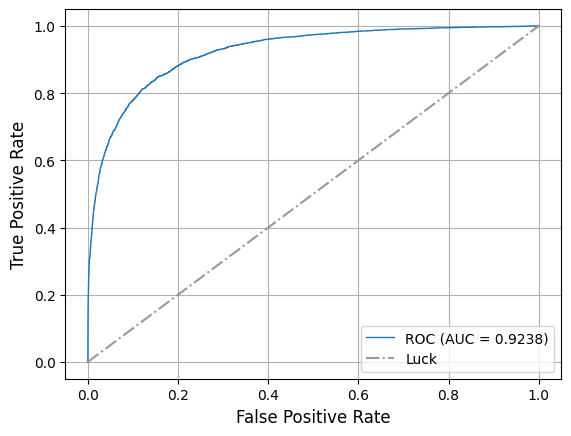

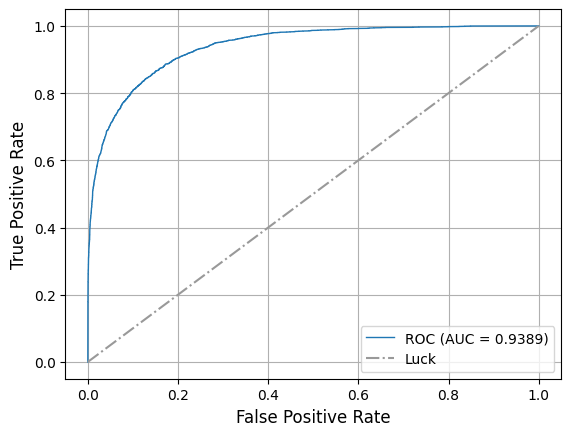

In [30]:
plot_utils.plot_roc(train_test_data[3], score_test);
score_train = model_hdl.predict(train_test_data[0],output_margin=False)
plot_utils.plot_roc(train_test_data[1], score_train);

itertools.combinations

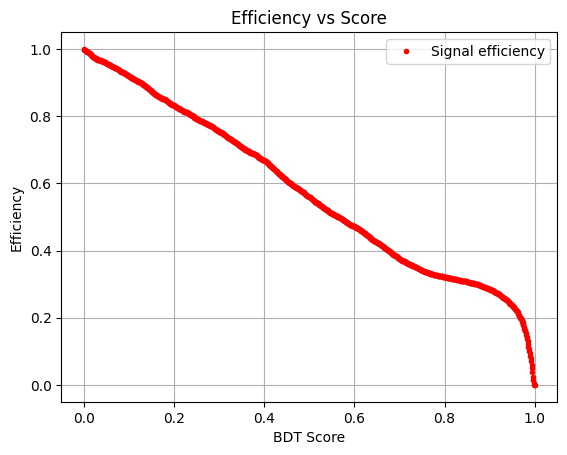

In [40]:
eff_array, score_array = analysis_utils.bdt_efficiency_array(train_test_data[3], score_test, 1000)
plot_utils.plot_bdt_eff(score_array, eff_array);

In [82]:
plot_utils.plot_feature_imp()

TypeError: plot_feature_imp() missing 3 required positional arguments: 'df_in', 'y_truth', and 'model'

Repeat this exercise with the training set: what do you get?

Training ROC-AUC is slightly higher than the test set one. This is a systematic behaviour due to the small presence of overfitting. We can see it also by plotting the BDT output for the training and test set distributions

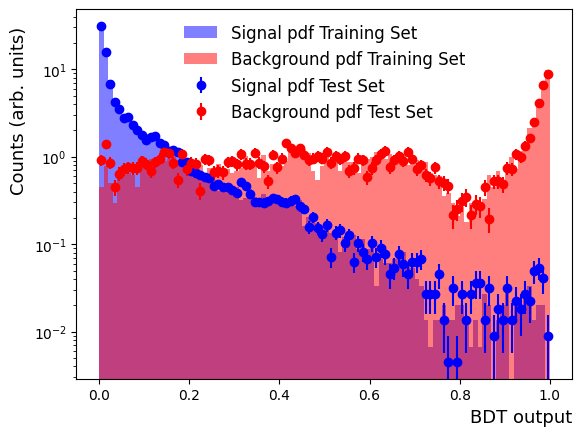

In [31]:
plot_utils.plot_output_train_test(model_hdl, train_test_data, density=True, bins=100, logscale=True,output_margin=False);

Now, before applying the BDT to data we can have a look at which variables are relevant for the training. We will use the feature importance implemented in the SHAP library (https://github.com/slundberg/shap). In the context of machine learning, the Shapley value is used to evaluate the contribution of each feature to the model output, and it is calculated by averaging the marginal contributions of each feature to the model output. The marginal contribution of a feature is the difference in the model output when the feature is present or absent. The variables that are
more important for the model are those that have a higher marginal contribution, and Shapley values consequently.

In hipe4ml the function plot_feat_imp implements the algorithm: try to use it!

In [32]:
from scipy.optimize import curve_fit
from scipy import integrate
from matplotlib.offsetbox import AnchoredText

def fit_invmass(df, fit_range=[1.660, 1.685]):
    
    # histogram of the data
    minXicMass=2.2
    maxXicMass=2.4
    binWidth=0.005 # GeV/c^2 ~ 4 MeV/c^2
    binsInvMass=int((maxXicMass-minXicMass)/binWidth);

    print('=====================================')
    print('Bins of Inv Mass plot: ',binsInvMass)
    print('=====================================')

    counts, bins = np.histogram(df, bins=binsInvMass, range=fit_range)
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(fit_range[0], fit_range[1], 0.00001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 2.28, 0.001])
    plt.figure(figsize=(10,8))
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='o', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r, gaus_function(r, N=popt[2], mu=popt[3], sigma=popt[4]), label='Gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green', linestyle='--')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+Gaus', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, fit_range[0], fit_range[1], args=(popt[2], popt[3], popt[4]))[0] / binWidth
    background = integrate.quad(pol2_function, fit_range[0], fit_range[1], args=(popt[0], popt[1]))[0] / binWidth
    signal_Unc = integrate.quad(gaus_function, fit_range[0], fit_range[1], args=(popt[2], popt[3], popt[4]))[1] / binWidth
    background_Unc = integrate.quad(pol2_function, fit_range[0], fit_range[1], args=(popt[0], popt[1]))[1] / binWidth
    sOverb = signal/background
    
    print(f'Sig : {signal:.0f}+-{signal_Unc:.3f}')
    print(f'Bkg : {background:.0f}+-{background_Unc:.3f}')     
    print(f'S/B : {sOverb:.2f}')     
    significance = signal / np.sqrt(signal + background)
    print(f'Significance: {significance:.0f}')     
    
    # ticks and tick-labels
    plt.minorticks_on()
    plt.tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
    plt.tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    txtCuts=r'$p_{\rm T}$ < 8 GeV/c'
    # info on plot
    txt=f'Sig:   {signal:.2f}\nBkg:  {background:.2f}\nS/B:   {sOverb:.2f}\n$S/\sqrt{{S+B}}$: {significance:.2f}'
    plt.annotate(txt, xy=(0.04, 0.95), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points',fontsize=18, linespacing=2, fontweight='normal', 
                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 7})
    txt2=f'$\mu$:  {popt[3]:.3f}\n$\sigma$:  {popt[4]:.3f}\nScore:({scoreMin:.2f}-{scoreMax:.2f})'

    plt.annotate(txt2, xy=(0.6, 0.3), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points',fontsize=16, linespacing=2, fontweight='normal', 
                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 7})
    # Add some axis labels
    plt.legend(fontsize=18,borderpad=1, labelspacing=0.8, frameon=False)
    plt.xlabel(r'$M_{\Lambda_c^+ \rightarrow pk\pi}$ $(\mathrm{GeV/}\it{c}^2)$',fontsize=20)
    plt.ylabel(f'Counts/({binWidth:.3f} GeV/$c^2$)',fontsize=20)
    plt.gca().set_ylim(top=counts.max()*1.8)
    plt.show()


### Applying the BDT

In [33]:
hdl_data_application.apply_model_handler(model_hdl,output_margin=False)

output_df=hdl_data_application.get_data_frame()

minScore=round(output_df.model_output.min(),2)
maxScore=round(output_df.model_output.max(),2)

minhalf=round(minScore/2,2)
minquarter=round(minScore/4 * 3,2)
minextreme=round(minScore/8 * 7,2)

maxhalf=round(maxScore/2,2)
maxquarter=round(maxScore/4 * 3,2)
maxextreme=round(maxScore/8 * 7,2)

listScoreMin=[minScore, minScore, minScore, minScore,    minScore,   0,         maxhalf,   maxquarter, maxextreme ]
listScoreMax=[maxScore, 0,        minhalf,  minquarter,  minextreme, maxScore,  maxScore,  maxScore,   maxScore   ]

print(listScoreMin)
print(listScoreMax)

print(minScore, maxScore)

[0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.5, 0.75, 0.88]
[1.0, 0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
0.0 1.0


Bins of Inv Mass plot:  39
Sig : 1735+-0.000
Bkg : 33069+-0.000
S/B : 0.05
Significance: 9


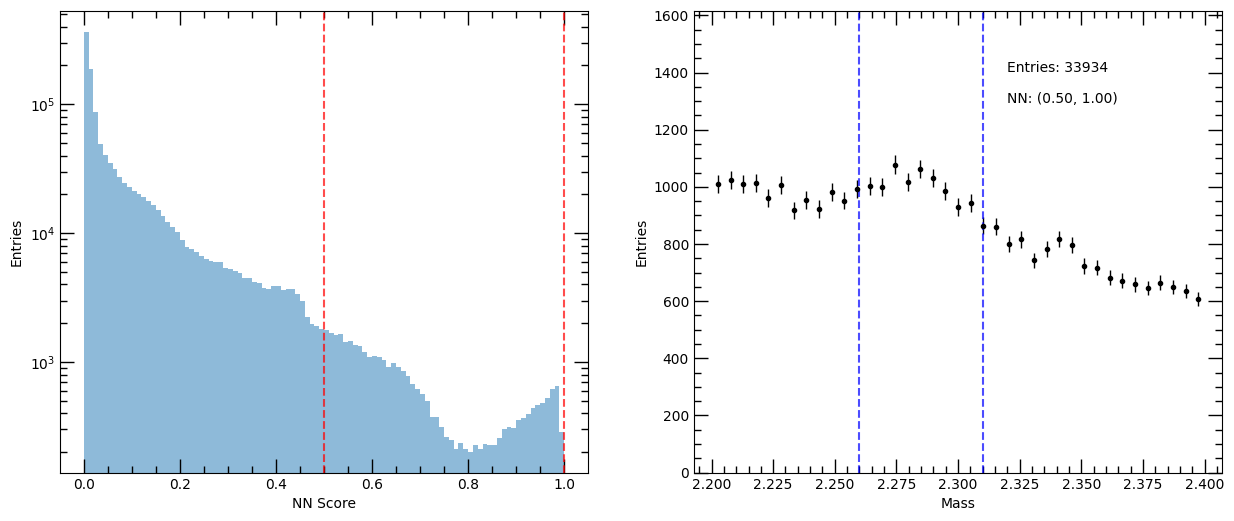

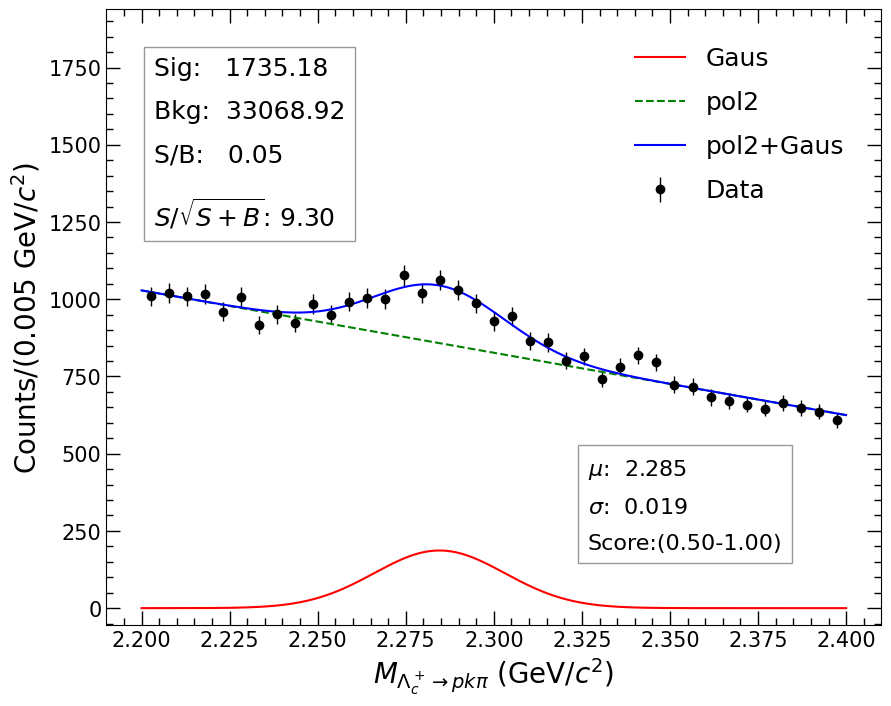

In [37]:
bigTicks=10
smallTicks=5

minMass=2.2
maxMass=2.4
binWidth=0.005 # GeV/c^2 ~ 4 MeV/c^2
binsInvMass=int((maxMass-minMass)/binWidth);


fig, ax = plt.subplots(1,2, figsize=(15,6))


scoreMin=0.5
# scoreMax=0.7
scoreMax=round(output_df.model_output.max(),2)

ptMin=1
ptMax=10



scoreCut=f'model_output > {scoreMin:.2f} & model_output < {scoreMax:.2f} & fPt > {ptMin:.2f} & fPt < {ptMax:.2f}'
ax[0].hist(output_df['model_output'],bins=100,alpha=0.5,log=1)
ax[0].minorticks_on()
ax[0].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
ax[0].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
ax[0].axvline(scoreMin, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[0].axvline(scoreMax, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[0].set_ylabel('Entries')
ax[0].set_xlabel('NN Score')


counts, bins = np.histogram(output_df.query(scoreCut)['fM'], bins=binsInvMass)
x_point = 0.5 * (bins[1:] + bins[:-1])
ax[1].errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
ax[1].set_ylim(bottom=0)
ax[1].set_ylim(top=counts.max()*1.5)
ax[1].minorticks_on()
textStr= f'NN: ({scoreMin:.2f}, {scoreMax:.2f})'
EntriesStr= f'Entries: {counts.sum()}'
ax[1].text(2.32,counts.max()*1.2, textStr )
ax[1].text(2.32,counts.max()*1.3, EntriesStr )
ax[1].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
ax[1].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
ax[1].set_ylabel('Entries')
ax[1].set_xlabel('Mass')
ax[1].axvline(2.26, 0, 1, label='pyplot vertical line',color='b',linestyle='--',alpha=0.7)
ax[1].axvline(2.31, 0, 1, label='pyplot vertical line',color='b',linestyle='--',alpha=0.7)
fit_invmass(output_df.query(scoreCut)['fM'], fit_range=[2.2, 2.4])

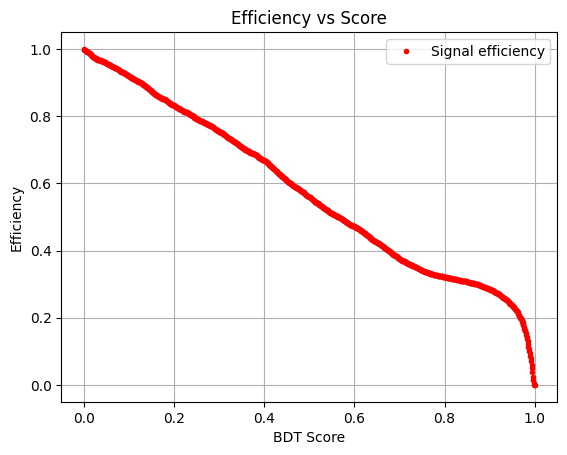

In [38]:
### hipe4ml has a function to do that! 


In [30]:
import pickle
pickle.dump(model_hdl, open('savedModels/savedNN.model', 'wb'))